# Tesing results of CelebA

## Preprocessing

In [1]:
# python libraties
import numpy as np
import os
import pandas as pd
from skimage import io
import argparse
from timeit import default_timer as timer

# pytorch libraries
import torch
import torchvision
import torchvision.transforms as transforms  # Transformations we can perform on our dataset
import torchvision.models as models
import torch.nn as nn  # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.optim as optim  # For all Optimization algorithms, SGD, Adam, etc.
import torch.nn.functional as F  # All functions that don't have any parameters
from torch.utils.data import (
    Dataset,
    DataLoader,
)  # Gives easier dataset managment and creates mini batches
import torchvision.datasets as datasets  # Has standard datasets we can import in a nice way
import torchvision.transforms as transforms  # Transformations we can perform on our dataset


In [2]:
###########################################################################
##########################  Data Preprocessing    #########################
###########################################################################


class CelebADataset(Dataset):
    def __init__(self, csv_file, root_dir, target, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.target = target

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = io.imread(img_path)
        # 1=Smiling; 2=Attractive
        if self.target == 'smile':
            y_label = torch.tensor(int(self.annotations.iloc[index, 1]))
        elif self.target == 'attractive':
            y_label = torch.tensor(int(self.annotations.iloc[index, 2]))

        bias = torch.tensor(int(self.annotations.iloc[index, 3]))

        if self.transform:
            image = self.transform(image)

        return (image, y_label, bias)
    
def Get_test_loader(data_dir, sensitive_type, img_type, target):
    test_root_dir = data_dir + sensitive_type + '/' + img_type + '/test'


    test_csv = data_dir + sensitive_type + '/' + sensitive_type +'_test.csv'


    test_set = CelebADataset(
        csv_file=test_csv,
        root_dir=test_root_dir,
        target = target,
        transform=transforms.ToTensor(),
    )

    test_num = len(test_set)

    test_loader = DataLoader(dataset=test_set, batch_size=1, shuffle=False)
    return test_loader, test_num, test_csv

In [3]:
def Get_saved_model_path(fairloss, data_dir, img_type, sensitive_type, target):
    saved_dir = data_dir + sensitive_type + '/model/' + target

    if fairloss:
        save_file_name = saved_dir + '/' + img_type + f'_best_model+fairloss.pt'
    else:
        save_file_name = saved_dir + '/' + img_type + f'_best_model.pt'

    return save_file_name

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model.to(device)

c:\Users\yaoru\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\yaoru\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Evaluation Modules

In [5]:
# Check accuracy on training to see how good our model is

def check_accuracy(predict_output, loader, model):
    num_correct = 0
    num_samples = 0
    i = 0
        
        
    model.eval()

    with torch.no_grad():
        for x, y, bias in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
                
            predict = predictions.data.cpu().numpy()
            predict_output[i] = predict
            i+=1

            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

        print(
            f"Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}%"
        )

        #model.train()



In [6]:
def ypos_zpos(a,b):
    if a==1 and b==1:
        return 1
    else:
        return 0

def ypos_zneg(a,b):
    if a==1 and b==0:
        return 1
    else:
        return 0

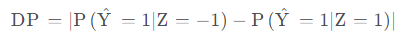

In [7]:
def Get_DP(predict_output, test_csv, sensitive_type, target):
    predict_output_df = pd.DataFrame(predict_output, columns = ['predict'])
    test = pd.read_csv(test_csv)

    sensitive = test[sensitive_type]
    frames = [predict_output_df, sensitive, test[target]]
    result = pd.concat(frames, axis=1)
    result['y=1z=1'] = result.apply(lambda result: ypos_zpos(result['predict'],result[sensitive_type]), axis=1)
    result['y=1z=-1'] = result.apply(lambda result: ypos_zneg(result['predict'],result[sensitive_type]), axis=1)

    if result[sensitive_type].value_counts().loc[0] == result[sensitive_type].value_counts().loc[1]:
        pos_sensitive_num = result[sensitive_type].value_counts().loc[0]

    DP = abs(result['y=1z=-1'].sum()/pos_sensitive_num - result['y=1z=1'].sum()/pos_sensitive_num)
    print('The value of DP is',DP)
    return result

In [8]:
def yhat1Y1Zn1(a,b,c):
        if a==1 and b==1 and c==0:
            return 1
        else:
            return 0

def yhat1Y1Z1(a,b,c):
    if a==1 and b==1 and c==1:
        return 1
    else:
        return 0

def Y1Zn1(a,b):
    if a==1 and b==0:
        return 1
    else:
        return 0

def Y1Z1(a,b):
    if a==1 and b==1:
        return 1
    else:
        return 0
    

def yhat1Yn1Zn1(a,b,c):
    if a==1 and b==0 and c==0:
        return 1
    else:
        return 0

def yhat1Yn1Z1(a,b,c):
    if a==1 and b==0 and c==1:
        return 1
    else:
        return 0

def Yn1Zn1(a,b):
    if a==0 and b==0:
        return 1
    else:
        return 0

def Yn1Z1(a,b):
    if a==0 and b==1:
        return 1
    else:
        return 0

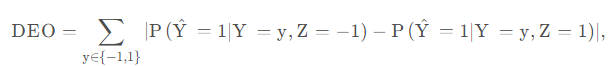

In [9]:
def Get_DEO(result, target, sensitive_type):
    result['yhat1Y1Zn1'] = result.apply(lambda result: yhat1Y1Zn1(result['predict'],result[target],result[sensitive_type]), axis=1)
    result['yhat1Y1Z1'] = result.apply(lambda result: yhat1Y1Z1(result['predict'],result[target],result[sensitive_type]), axis=1)

    result['Y1Zn1'] = result.apply(lambda result: Y1Zn1(result[target],result[sensitive_type]), axis=1)
    result['Y1Z1'] = result.apply(lambda result: Y1Z1(result[target],result[sensitive_type]), axis=1)

    result['yhat1Yn1Zn1'] = result.apply(lambda result: yhat1Yn1Zn1(result['predict'],result[target],result[sensitive_type]), axis=1)
    result['yhat1Yn1Z1'] = result.apply(lambda result: yhat1Yn1Z1(result['predict'],result[target],result[sensitive_type]), axis=1)

    result['Yn1Zn1'] = result.apply(lambda result: Yn1Zn1(result[target],result[sensitive_type]), axis=1)
    result['Yn1Z1'] = result.apply(lambda result: Yn1Z1(result[target],result[sensitive_type]), axis=1)

    DEO = (abs(result['yhat1Y1Zn1'].sum()/result['Y1Zn1'].sum() - result['yhat1Y1Z1'].sum()/result['Y1Z1'].sum()) + 
        abs(result['yhat1Yn1Zn1'].sum()/result['Yn1Zn1'].sum() - result['yhat1Yn1Z1'].sum()/result['Yn1Z1'].sum()))

    print('The value of DEO is',DEO)

In [10]:
def eval(data_dir, sensitive_type, img_type, target, fairloss):
    test_loader, test_num, test_csv = Get_test_loader(data_dir, sensitive_type, img_type, target)
    save_file_name = Get_saved_model_path(fairloss, data_dir, img_type, sensitive_type, target)
    print('Evaluating Model')
    model.load_state_dict(torch.load(save_file_name))
    model.eval()

    print("Checking accuracy on Test Set")
    predict_output = np.zeros((test_num, 1), dtype=int)
    check_accuracy(predict_output, test_loader, model)

    result = Get_DP(predict_output, test_csv, sensitive_type, target)

    Get_DEO(result, target, sensitive_type)

## Evaluation Result (sensitive_type = 'gender', target = 'smile')

### Original images, no fairloss

In [11]:
data_dir = './dataset/'
sensitive_type = 'gender'
img_type = 'origin'
target = 'smile'
fairloss = False

eval(data_dir, sensitive_type, img_type, target, fairloss)

Evaluating Model
Checking accuracy on Test Set
Got 1353 / 1500 with accuracy 90.20%
The value of DP is 0.14
The value of DEO is 0.09636653549314053


### Grayscale images, no fairloss

In [12]:
data_dir = './dataset/'
sensitive_type = 'gender'
img_type = 'grey'
target = 'smile'
fairloss = False

eval(data_dir, sensitive_type, img_type, target, fairloss)

Evaluating Model
Checking accuracy on Test Set
Got 1362 / 1500 with accuracy 90.80%
The value of DP is 0.17866666666666664
The value of DEO is 0.1460944332861715


### Sketch images, no fairloss

In [35]:
data_dir = './dataset/'
sensitive_type = 'gender'
img_type = 'sketch'
target = 'smile'
fairloss = False

eval(data_dir, sensitive_type, img_type, target, fairloss)

Evaluating Model
Checking accuracy on Test Set
Got 1365 / 1500 with accuracy 91.00%
The value of DP is 0.11066666666666669
The value of DEO is 0.04136896406078278


### Sketch images with fairloss

In [36]:
data_dir = './dataset/'
sensitive_type = 'gender'
img_type = 'sketch'
target = 'smile'
fairloss = True

eval(data_dir, sensitive_type, img_type, target, fairloss)

Evaluating Model
Checking accuracy on Test Set
Got 1363 / 1500 with accuracy 90.87%
The value of DP is 0.10533333333333333
The value of DEO is 0.06818235299683663


## Evaluation Result (sensitive_type = 'skin_color', target = 'smile')

### Original images, no fairloss

In [15]:
data_dir = './dataset/'
sensitive_type = 'skin_color'
img_type = 'origin'
target = 'smile'
fairloss = False

eval(data_dir, sensitive_type, img_type, target, fairloss)

Evaluating Model
Checking accuracy on Test Set
Got 1385 / 1500 with accuracy 92.33%
The value of DP is 0.16133333333333333
The value of DEO is 0.06281971882238513


### Grayscale images, no fairloss

In [16]:
data_dir = './dataset/'
sensitive_type = 'skin_color'
img_type = 'grey'
target = 'smile'
fairloss = False

eval(data_dir, sensitive_type, img_type, target, fairloss)

Evaluating Model
Checking accuracy on Test Set
Got 1374 / 1500 with accuracy 91.60%
The value of DP is 0.13066666666666665
The value of DEO is 0.06507360010183683


### Sketch images, no fairloss

In [17]:
data_dir = './dataset/'
sensitive_type = 'skin_color'
img_type = 'sketch'
target = 'smile'
fairloss = False

eval(data_dir, sensitive_type, img_type, target, fairloss)

Evaluating Model
Checking accuracy on Test Set
Got 1373 / 1500 with accuracy 91.53%
The value of DP is 0.132
The value of DEO is 0.028182534184150766


### Sketch images with fairloss

In [18]:
data_dir = './dataset/'
sensitive_type = 'skin_color'
img_type = 'sketch'
target = 'smile'
fairloss = True

eval(data_dir, sensitive_type, img_type, target, fairloss)

Evaluating Model
Checking accuracy on Test Set
Got 1362 / 1500 with accuracy 90.80%
The value of DP is 0.10399999999999998
The value of DEO is 0.04951045177096439


## Evaluation Result (sensitive_type = 'hair_color', target = 'smile')

### Original images, no fairloss

In [19]:
data_dir = './dataset/'
sensitive_type = 'hair_color'
img_type = 'origin'
target = 'smile'
fairloss = False

eval(data_dir, sensitive_type, img_type, target, fairloss)

Evaluating Model
Checking accuracy on Test Set
Got 1369 / 1500 with accuracy 91.27%
The value of DP is 0.061333333333333295
The value of DEO is 0.05481875442089432


### Grayscale images, no fairloss

In [20]:
data_dir = './dataset/'
sensitive_type = 'hair_color'
img_type = 'grey'
target = 'smile'
fairloss = False

eval(data_dir, sensitive_type, img_type, target, fairloss)

Evaluating Model
Checking accuracy on Test Set
Got 1376 / 1500 with accuracy 91.73%
The value of DP is 0.05199999999999999
The value of DEO is 0.03475528871241852


### Sketch images, no fairloss

In [21]:
data_dir = './dataset/'
sensitive_type = 'hair_color'
img_type = 'sketch'
target = 'smile'
fairloss = False

eval(data_dir, sensitive_type, img_type, target, fairloss)

Evaluating Model
Checking accuracy on Test Set
Got 1356 / 1500 with accuracy 90.40%
The value of DP is 0.05466666666666664
The value of DEO is 0.04265812806045176


### Sketch images with fairloss

In [22]:
data_dir = './dataset/'
sensitive_type = 'hair_color'
img_type = 'sketch'
target = 'smile'
fairloss = True

eval(data_dir, sensitive_type, img_type, target, fairloss)

Evaluating Model
Checking accuracy on Test Set
Got 1337 / 1500 with accuracy 89.13%
The value of DP is 0.037333333333333385
The value of DEO is 0.012225679468179748


## Evaluation Result (sensitive_type = 'gender', target = 'attractive')

### Original images, no fairloss

In [23]:
data_dir = './dataset/'
sensitive_type = 'gender'
img_type = 'origin'
target = 'attractive'
fairloss = False

eval(data_dir, sensitive_type, img_type, target, fairloss)

Evaluating Model
Checking accuracy on Test Set
Got 1219 / 1500 with accuracy 81.27%
The value of DP is 0.5066666666666666
The value of DEO is 0.5863539565653754


### Grayscale images, no fairloss

In [24]:
data_dir = './dataset/'
sensitive_type = 'gender'
img_type = 'grey'
target = 'attractive'
fairloss = False

eval(data_dir, sensitive_type, img_type, target, fairloss)

Evaluating Model
Checking accuracy on Test Set
Got 1225 / 1500 with accuracy 81.67%
The value of DP is 0.4826666666666667
The value of DEO is 0.52323491554943


### Sketch images, no fairloss

In [25]:
data_dir = './dataset/'
sensitive_type = 'gender'
img_type = 'sketch'
target = 'attractive'
fairloss = False

eval(data_dir, sensitive_type, img_type, target, fairloss)

Evaluating Model
Checking accuracy on Test Set
Got 1184 / 1500 with accuracy 78.93%
The value of DP is 0.42533333333333334
The value of DEO is 0.44566689546189825


### Sketch images with fairloss

In [39]:
data_dir = './dataset/'
sensitive_type = 'gender'
img_type = 'sketch'
target = 'attractive'
fairloss = True

eval(data_dir, sensitive_type, img_type, target, fairloss)

Evaluating Model
Checking accuracy on Test Set
Got 941 / 1500 with accuracy 62.73%
The value of DP is 0.16533333333333333
The value of DEO is 0.18046849180306154


## Evaluation Result (sensitive_type = 'skin_color', target = 'attractive')

### Original images, no fairloss

In [27]:
data_dir = './dataset/'
sensitive_type = 'skin_color'
img_type = 'origin'
target = 'attractive'
fairloss = False

eval(data_dir, sensitive_type, img_type, target, fairloss)

Evaluating Model
Checking accuracy on Test Set
Got 1214 / 1500 with accuracy 80.93%
The value of DP is 0.27866666666666673
The value of DEO is 0.3371141317937657


### Grayscale images, no fairloss

In [28]:
data_dir = './dataset/'
sensitive_type = 'skin_color'
img_type = 'grey'
target = 'attractive'
fairloss = False

eval(data_dir, sensitive_type, img_type, target, fairloss)

Evaluating Model
Checking accuracy on Test Set
Got 1204 / 1500 with accuracy 80.27%
The value of DP is 0.31066666666666665
The value of DEO is 0.35624586556814586


### Sketch images, no fairloss

In [29]:
data_dir = './dataset/'
sensitive_type = 'skin_color'
img_type = 'sketch'
target = 'attractive'
fairloss = False

eval(data_dir, sensitive_type, img_type, target, fairloss)

Evaluating Model
Checking accuracy on Test Set
Got 1171 / 1500 with accuracy 78.07%
The value of DP is 0.19466666666666665
The value of DEO is 0.20403768729511246


### Sketch images with fairloss

In [30]:
data_dir = './dataset/'
sensitive_type = 'skin_color'
img_type = 'sketch'
target = 'attractive'
fairloss = True

eval(data_dir, sensitive_type, img_type, target, fairloss)

Evaluating Model
Checking accuracy on Test Set
Got 1112 / 1500 with accuracy 74.13%
The value of DP is 0.15066666666666673
The value of DEO is 0.17798496236062156


## Evaluation Result (sensitive_type = 'hair_color', target = 'attractive')

### Original images, no fairloss

In [31]:
data_dir = './dataset/'
sensitive_type = 'hair_color'
img_type = 'origin'
target = 'attractive'
fairloss = False

eval(data_dir, sensitive_type, img_type, target, fairloss)

Evaluating Model
Checking accuracy on Test Set
Got 1203 / 1500 with accuracy 80.20%
The value of DP is 0.07066666666666666
The value of DEO is 0.09160565202632534


### Grayscale images, no fairloss

In [32]:
data_dir = './dataset/'
sensitive_type = 'hair_color'
img_type = 'grey'
target = 'attractive'
fairloss = False

eval(data_dir, sensitive_type, img_type, target, fairloss)

Evaluating Model
Checking accuracy on Test Set
Got 1187 / 1500 with accuracy 79.13%
The value of DP is 0.046666666666666634
The value of DEO is 0.14120055532412984


### Sketch images, no fairloss

In [33]:
data_dir = './dataset/'
sensitive_type = 'hair_color'
img_type = 'sketch'
target = 'attractive'
fairloss = False

eval(data_dir, sensitive_type, img_type, target, fairloss)

Evaluating Model
Checking accuracy on Test Set
Got 1169 / 1500 with accuracy 77.93%
The value of DP is 0.022666666666666613
The value of DEO is 0.08486769810143865


### Sketch images with fairloss

In [34]:
data_dir = './dataset/'
sensitive_type = 'hair_color'
img_type = 'sketch'
target = 'attractive'
fairloss = True

eval(data_dir, sensitive_type, img_type, target, fairloss)

Evaluating Model
Checking accuracy on Test Set
Got 1165 / 1500 with accuracy 77.67%
The value of DP is 0.03333333333333327
The value of DEO is 0.05636236095238728
